In [1]:
pip install numpy torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# --- Celda 1: Importaciones y Carga del Modelo (CORREGIDA) ---
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import os

# --- IMPORTANTE: Configurar para CPU ---
device = torch.device("cpu")
print(f"Usando dispositivo: {device}")

# --- CORRECCIÓN: Definir los nombres de las clases ---
class_names = ['NORMAL', 'PNEUMONIA']
# ---------------------------------------------------

# 1. Definir la misma arquitectura de modelo que en Colab
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# 2. Cargar los pesos guardados
model_path = "resnet18_xray_best.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval() # Poner el modelo en modo de evaluación

print("Modelo cargado exitosamente en CPU.")

Usando dispositivo: cpu
Modelo cargado exitosamente en CPU.


In [14]:
# --- Celda 2: Cargar los Datos Pre-generados ---
print("Cargando datos pre-generados...")

try:
    benign_images = np.load("benign_images_xray.npy")
    adv_images = np.load("adv_images_xray.npy")
    adv_distances = np.load("adv_distances_xray.npy")
    print(f"Cargados {len(benign_images)} pares de imágenes.")
    print(f"Forma del array de imágenes benignas: {benign_images.shape}")
except FileNotFoundError:
    print("Error: No se encontraron los archivos .npy. Asegúrate de que están en la misma carpeta que este notebook.")

Cargando datos pre-generados...
Cargados 30 pares de imágenes.
Forma del array de imágenes benignas: (30, 224, 224, 3)


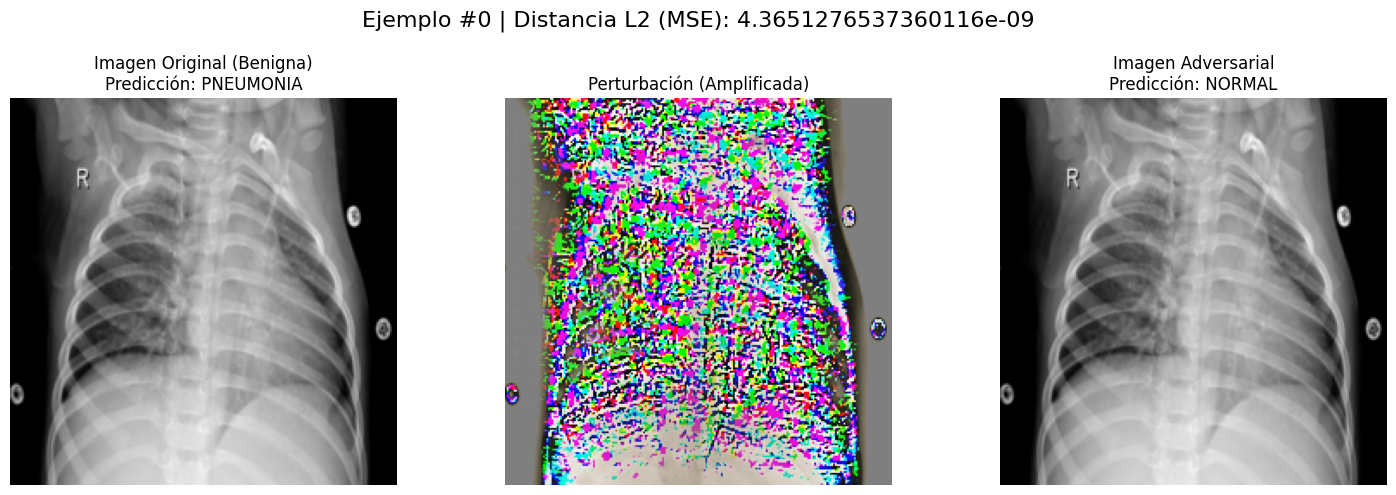

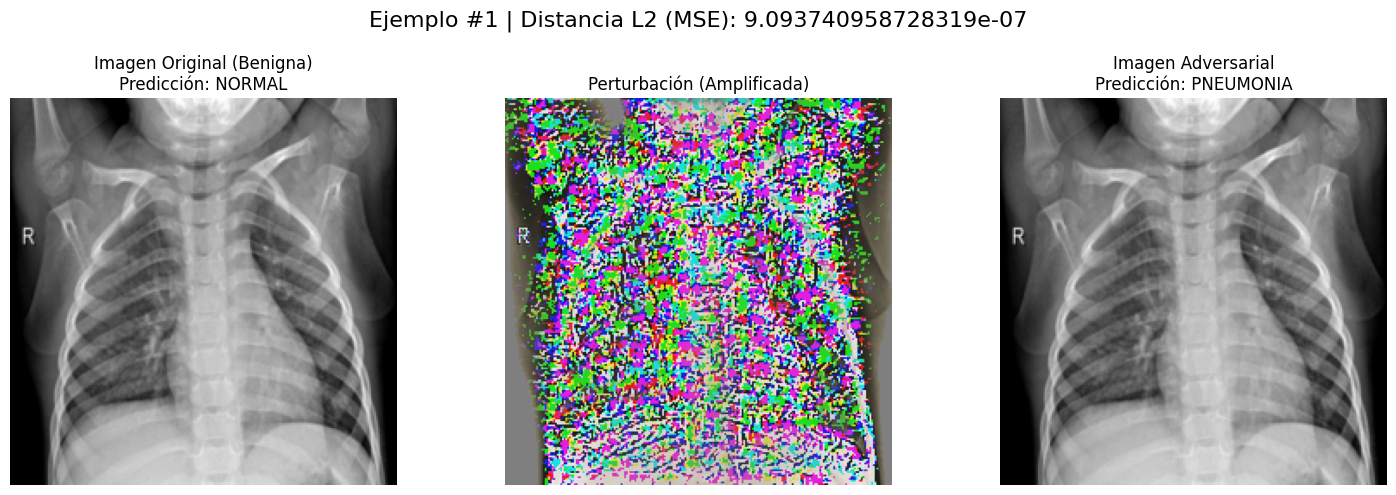

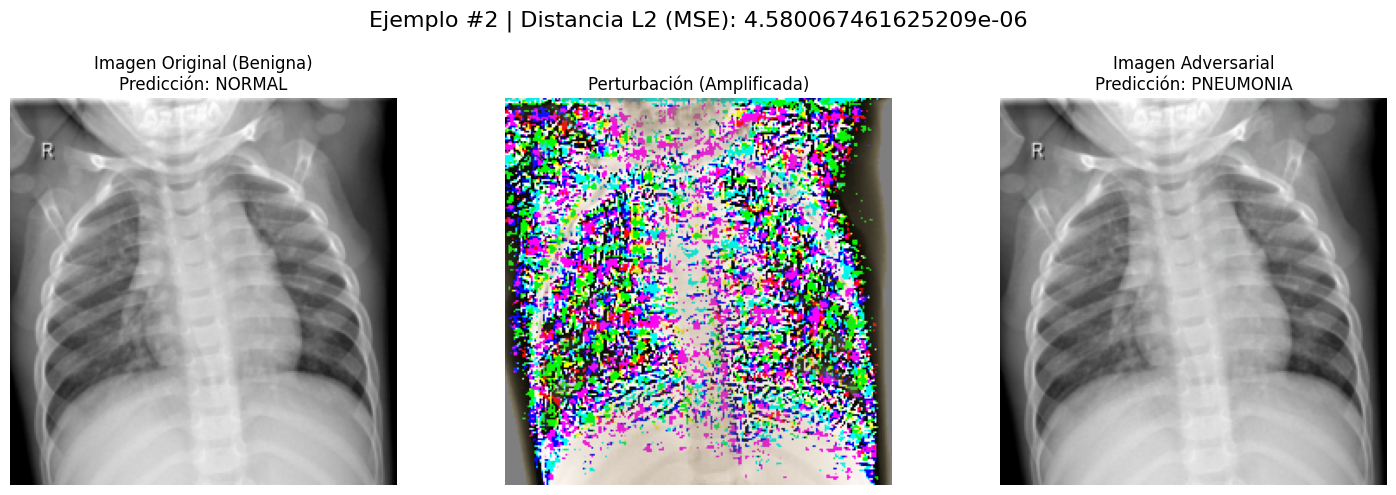

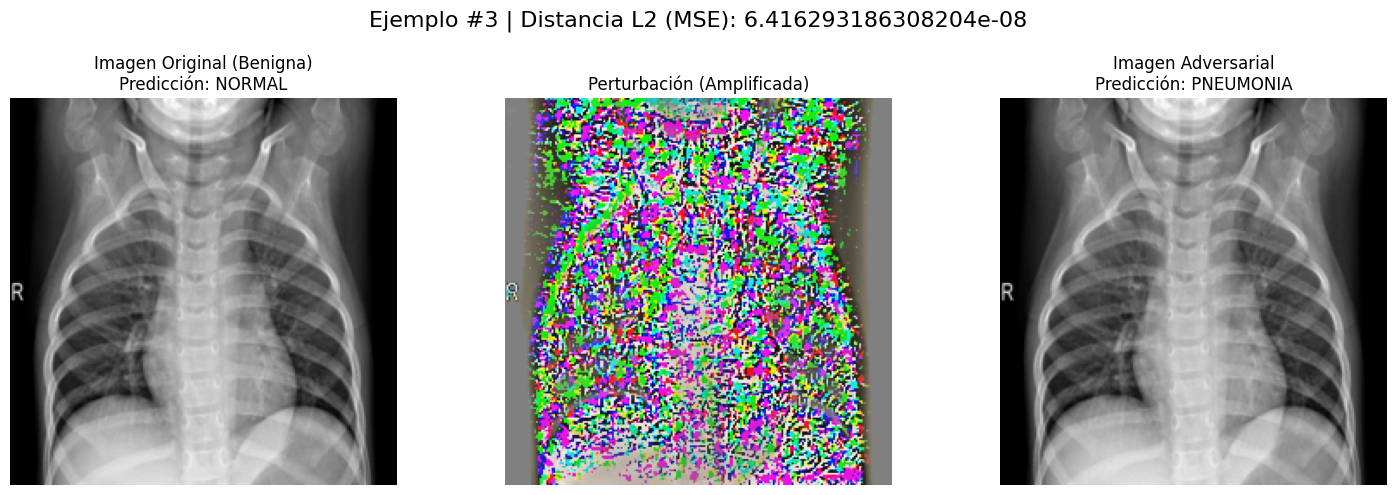

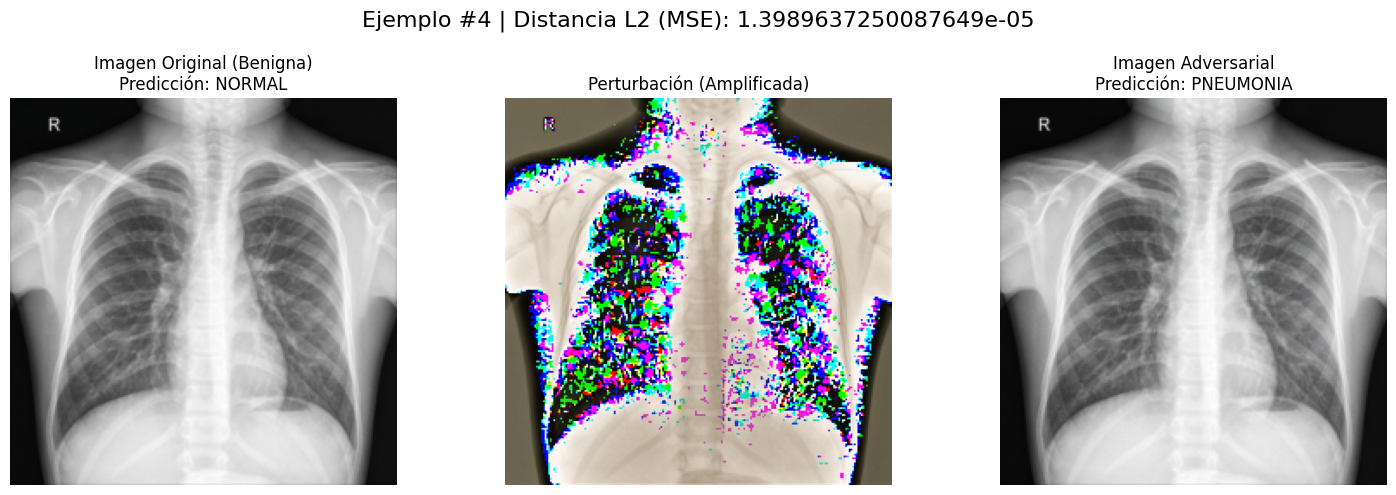

In [16]:
# --- Celda 3: Función de Visualización y Ploteo ---

def plot_adversarial_pair(index, benign_imgs, adv_imgs, distances, model, device):
    """
    Toma un índice y plotea el par benigno/adversarial, junto con la perturbación.
    """
    if index >= len(benign_imgs):
        print(f"Índice fuera de rango. Por favor elige un número entre 0 y {len(benign_imgs) - 1}.")
        return

    # Seleccionar las imágenes
    benign_np = benign_imgs[index]
    adv_np = adv_imgs[index]
    distance = distances[index]

    # --- Des-normalización para visualización ---
    # Es el proceso inverso a las transformaciones que aplicamos
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    benign_vis = np.clip(benign_np * std + mean, 0, 1)
    adv_vis = np.clip(adv_np * std + mean, 0, 1)
    
    # Calcular y normalizar la perturbación para que sea visible
    perturbation = adv_vis - benign_vis
    perturbation_vis = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())

    # --- Obtener Predicciones ---
    with torch.no_grad():
        # Preparar imágenes para el modelo (añadir batch y cambiar a C,H,W)
        benign_tensor = torch.from_numpy(np.transpose(benign_np, (2, 0, 1))).unsqueeze(0).float().to(device)
        adv_tensor = torch.from_numpy(np.transpose(adv_np, (2, 0, 1))).unsqueeze(0).float().to(device)
        
        benign_pred = torch.max(model(benign_tensor), 1)[1].item()
        adv_pred = torch.max(model(adv_tensor), 1)[1].item()

    # --- Ploteo ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(benign_vis)
    axes[0].set_title(f"Imagen Original (Benigna)\nPredicción: {class_names[benign_pred]}")
    axes[0].axis('off')

    axes[1].imshow(perturbation_vis)
    axes[1].set_title("Perturbación (Amplificada)")
    axes[1].axis('off')

    axes[2].imshow(adv_vis)
    axes[2].set_title(f"Imagen Adversarial\nPredicción: {class_names[adv_pred]}")
    axes[2].axis('off')
    
    plt.suptitle(f"Ejemplo #{index} | Distancia L2 (MSE): {distance}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Visualizar varios ejemplos ---
# Ploteamos los primeros 5 ejemplos que generaste
for i in range(min(5, len(benign_images))):
    plot_adversarial_pair(i, benign_images, adv_images, adv_distances, model, device)

In [10]:
import sys
import os
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from models.pytorch import PyTorchModel
from attacks.carlini_wagner import CarliniWagnerL2Attack
from criteria import Misclassification
from distances import MeanSquaredDistance as MSE
from adversarial import Adversarial
from pca_detector import find_kp_point

mean = 0.1307; std = 0.3081
min_val, max_val = (0 - mean) / std, (1 - mean) / std

fmodel = PyTorchModel(model, bounds=(min_val, max_val), num_classes=10, channel_axis=1, device=device)

print("\nCalculando puntos (k, p)...")
benign_kp_points = []
for i, img in enumerate(benign_images):
    print(f"Procesando imagen benigna {i+1}/{len(benign_images)}")
    kp_point = find_kp_point(img, fmodel)
    if kp_point[0] is not None:
        benign_kp_points.append(kp_point)

adv_kp_points = []
for i, img in enumerate(adv_images):
    print(f"Procesando imagen adversarial {i+1}/{len(adv_images)}")
    kp_point = find_kp_point(img, fmodel)
    if kp_point[0] is not None:
        adv_kp_points.append(kp_point)


Calculando puntos (k, p)...
Procesando imagen benigna 1/30
Procesando imagen benigna 2/30
Procesando imagen benigna 3/30
Procesando imagen benigna 4/30
Procesando imagen benigna 5/30
Procesando imagen benigna 6/30
Procesando imagen benigna 7/30
Procesando imagen benigna 8/30
Procesando imagen benigna 9/30
Procesando imagen benigna 10/30
Procesando imagen benigna 11/30
Procesando imagen benigna 12/30
Procesando imagen benigna 13/30
Procesando imagen benigna 14/30
Procesando imagen benigna 15/30
Procesando imagen benigna 16/30
Procesando imagen benigna 17/30
Procesando imagen benigna 18/30
Procesando imagen benigna 19/30
Procesando imagen benigna 20/30
Procesando imagen benigna 21/30
Procesando imagen benigna 22/30
Procesando imagen benigna 23/30
Procesando imagen benigna 24/30
Procesando imagen benigna 25/30
Procesando imagen benigna 26/30
Procesando imagen benigna 27/30
Procesando imagen benigna 28/30
Procesando imagen benigna 29/30
Procesando imagen benigna 30/30
Procesando imagen ad


Mejor umbral para 'k' encontrado: 61
Precisión de detección con este umbral: 56.67%


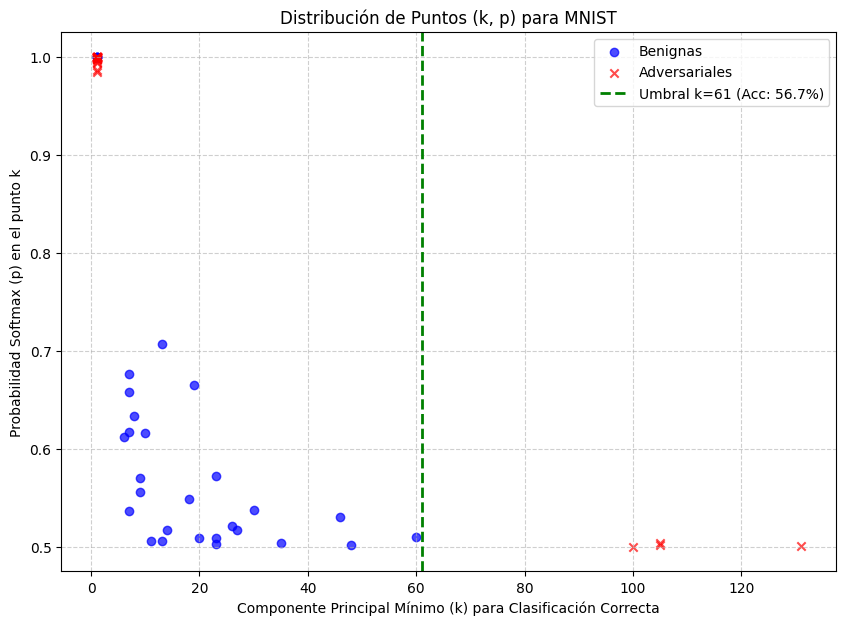

In [11]:

# --- Celda 6: Visualizar los Resultados y Detección con Umbral ---
if not benign_kp_points or not adv_kp_points:
    print("No se pudieron calcular suficientes puntos (k,p) para visualizar.")
else:
    benign_k, benign_p = zip(*benign_kp_points)
    adv_k, adv_p = zip(*adv_kp_points)

    plt.figure(figsize=(10, 7))
    plt.scatter(benign_k, benign_p, alpha=0.7, label='Benignas', c='blue')
    plt.scatter(adv_k, adv_p, alpha=0.7, label='Adversariales', c='red', marker='x')
    plt.title('Distribución de Puntos (k, p) para MNIST')
    plt.xlabel('Componente Principal Mínimo (k) para Clasificación Correcta')
    plt.ylabel('Probabilidad Softmax (p) en el punto k')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # --- Detección Basada en Umbral con NumPy ---
    all_k = np.array(benign_k + adv_k)
    # 0 para benigno, 1 para adversarial
    true_labels = np.array([0] * len(benign_k) + [1] * len(adv_k))

    best_threshold = 0
    best_accuracy = 0

    # Probar todos los posibles umbrales para 'k'
    possible_thresholds = np.arange(1, int(np.max(all_k)) + 1)
    for threshold in possible_thresholds:
        # Regla: si k >= umbral, es adversarial (1)
        predicted_labels = (all_k >= threshold).astype(int)
        # Calcular precisión: (verdaderos positivos + verdaderos negativos) / total
        accuracy = np.mean(predicted_labels == true_labels)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    print(f"\nMejor umbral para 'k' encontrado: {best_threshold}")
    print(f"Precisión de detección con este umbral: {best_accuracy * 100:.2f}%")

    # Dibujar la línea de umbral en el gráfico
    plt.axvline(x=best_threshold, color='green', linestyle='--', linewidth=2, label=f'Umbral k={best_threshold} (Acc: {best_accuracy*100:.1f}%)')
    plt.legend() # Actualizar leyenda
    plt.show()


--- Detección Mejorada con Regla 2D (k y p) ---
Mejor regla 2D encontrada: k < 61 Y p >= 0.00 -> Benigno
Precisión de detección con esta regla 2D: 56.67%


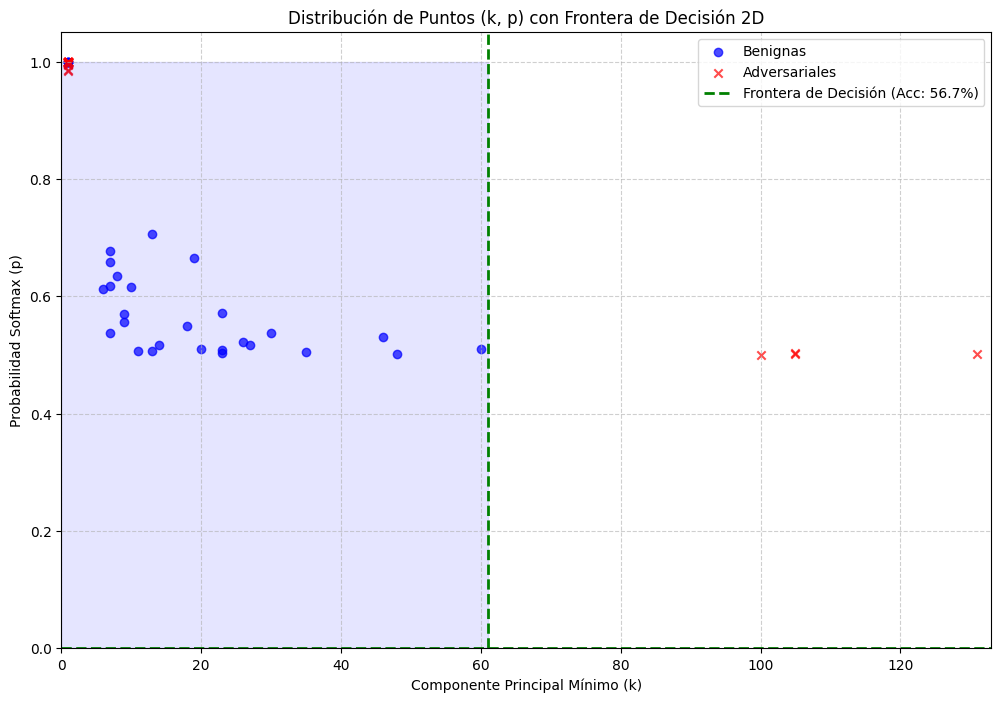

In [12]:
# --- NUEVA Celda 6: Detección Mejorada con Regla 2D (k y p) ---

if not benign_kp_points or not adv_kp_points:
    print("No se pudieron calcular suficientes puntos (k,p) para la detección.")
else:
    print("\n--- Detección Mejorada con Regla 2D (k y p) ---")
    
    benign_k, benign_p = zip(*benign_kp_points)
    adv_k, adv_p = zip(*adv_kp_points)
    
    # Juntar todos los datos
    all_k = np.array(benign_k + adv_k)
    all_p = np.array(benign_p + adv_p)
    # 0 para benigno, 1 para adversarial
    true_labels = np.array([0] * len(benign_k) + [1] * len(adv_k))

    best_k_threshold = 0
    best_p_threshold = 0
    best_accuracy = 0

    # Probar todos los posibles umbrales para 'k'
    possible_k_thresholds = np.arange(1, int(np.max(all_k)) + 2)
    # Probar umbrales para 'p' en incrementos de 0.05
    possible_p_thresholds = np.arange(0.0, 1.01, 0.05)

    for k_thresh in possible_k_thresholds:
        for p_thresh in possible_p_thresholds:
            # Regla 2D: Es adversarial (1) si (k >= k_thresh) O (p < p_thresh)
            # Esto define una región "benigna" donde k es bajo y p es alta.
            # Lo contrario es: es benigno (0) si (k < k_thresh) Y (p >= p_thresh)
            
            # Calculamos las predicciones para cada punto
            # Si un punto cumple la condición de benignidad, se le asigna 0, si no, 1.
            is_k_low = (all_k < k_thresh)
            is_p_high = (all_p >= p_thresh)
            
            # Un punto es predicho como benigno (0) solo si ambas condiciones son verdaderas
            predicted_as_benign = np.logical_and(is_k_low, is_p_high)
            
            # Las predicciones finales son lo contrario de ser predicho como benigno
            predicted_labels = 1 - predicted_as_benign.astype(int)

            accuracy = np.mean(predicted_labels == true_labels)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_k_threshold = k_thresh
                best_p_threshold = p_thresh

    print(f"Mejor regla 2D encontrada: k < {best_k_threshold} Y p >= {best_p_threshold:.2f} -> Benigno")
    print(f"Precisión de detección con esta regla 2D: {best_accuracy * 100:.2f}%")

    # --- Visualización con la Frontera de Decisión 2D ---
    plt.figure(figsize=(12, 8))
    plt.scatter(benign_k, benign_p, alpha=0.7, label='Benignas', c='blue')
    plt.scatter(adv_k, adv_p, alpha=0.7, label='Adversariales', c='red', marker='x')

    # Dibujar la frontera de decisión rectangular
    # Línea vertical para el umbral de k
    plt.axvline(x=best_k_threshold, color='green', linestyle='--', linewidth=2, 
                label=f'Frontera de Decisión (Acc: {best_accuracy*100:.1f}%)')
    # Línea horizontal para el umbral de p
    plt.axhline(y=best_p_threshold, color='green', linestyle='--', linewidth=2)
    
    # Rellenar el área "Benigna" para mayor claridad
    plt.fill_between([0, best_k_threshold], best_p_threshold, 1.0, color='blue', alpha=0.1)

    plt.title('Distribución de Puntos (k, p) con Frontera de Decisión 2D')
    plt.xlabel('Componente Principal Mínimo (k)')
    plt.ylabel('Probabilidad Softmax (p)')
    plt.xlim(left=0, right=int(np.max(all_k)) + 2)
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()